In [160]:
%pip install pyyaml==6.0.1
%pip install 'git+https://github.com/facebookresearch/detectron2.git'
%pip install pycocotools>=2.0.7
%pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
%pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu121/torch2.2.1/index.html
%pip install opencv-python
%pip install tensorboard
%pip install matplotlib
%pip install imageio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-oaf3uv7x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-oaf3uv7x
  Resolved https://github.com/facebookresearch/detectron2.git to commit afe9eb920646102f7e6bf0cd2115841cea2aca13
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-p

In [2]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import imageio.v2 as imageio

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

In [4]:
# prepare cifar dataset for bird vs airplane classification

data_path = './dlwpt-code/cifar10'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
)
transformed_cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
)

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# убеждаемся что датасет загрузился
%ls ./dlwpt-code/cifar10/

bird.jpeg              cifar-10-batches-py/    plane.jpg
birds_vs_airplanes.pt  cifar-10-python.tar.gz


In [6]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [7]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

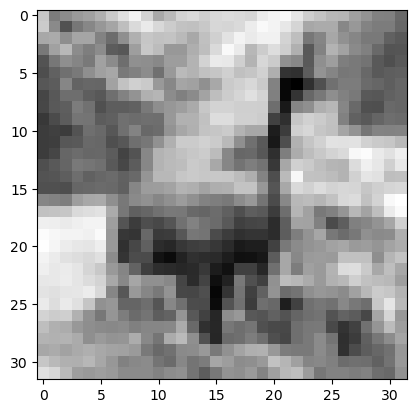

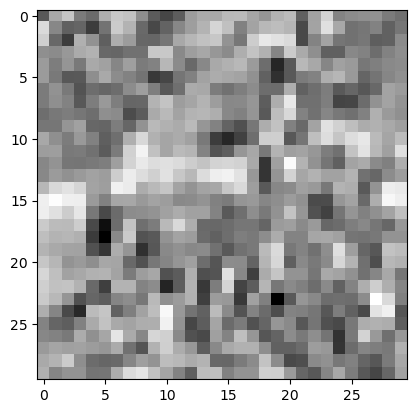

In [9]:
# input img
plt.imshow(img.unsqueeze(0)[0, 0].detach(), cmap='gray')
plt.show()

# output img after convolution
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [11]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

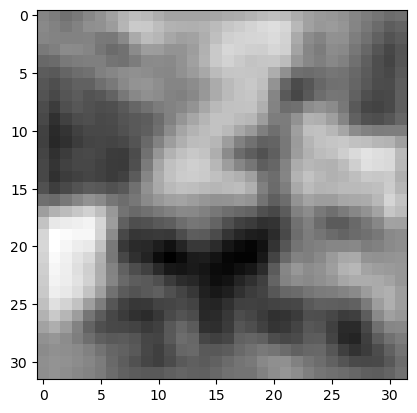

In [12]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [14]:
# пулинг в данном случае - выбор максимального значения пикселя из 2х2 квадрата
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

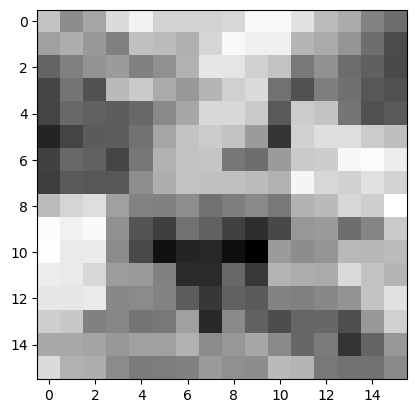

In [15]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh(),
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [53]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [23]:
model = Net()

In [24]:
model(img.unsqueeze(0))

tensor([[0.0563, 0.1308]], grad_fn=<AddmmBackward0>)

In [25]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)))

In [147]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2024-04-02 09:37:12.382429 Epoch 1, Training loss 0.5779909341578271
2024-04-02 09:37:19.854080 Epoch 10, Training loss 0.32604697327704946
2024-04-02 09:37:29.634343 Epoch 20, Training loss 0.2899473145319398
2024-04-02 09:37:37.930188 Epoch 30, Training loss 0.2701427714460215
2024-04-02 09:37:46.134052 Epoch 40, Training loss 0.25280648749914897
2024-04-02 09:37:54.638190 Epoch 50, Training loss 0.23626278748937474
2024-04-02 09:38:04.342929 Epoch 60, Training loss 0.2226316676397992
2024-04-02 09:38:12.605887 Epoch 70, Training loss 0.20789329845244717
2024-04-02 09:38:20.926254 Epoch 80, Training loss 0.19431113987971263
2024-04-02 09:38:29.250268 Epoch 90, Training loss 0.1790397450517697
2024-04-02 09:38:37.446196 Epoch 100, Training loss 0.1632094590384869


In [26]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)


def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name, correct / total))


validate(model, train_loader, val_loader)

Accuracy train: 0.51
Accuracy val: 0.52


In [27]:
def training_loop_with_validation(n_epochs, optimizer, model, loss_fn, train_loader):
    print(f"Training on device {device}.")
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)))
            train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
            val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)
            validate(model, train_loader, val_loader)

In [150]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=70,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.
2024-04-02 09:38:39.077619 Epoch 1, Training loss 0.5546117673633965
Accuracy train: 0.78
Accuracy val: 0.79
2024-04-02 09:38:47.958812 Epoch 10, Training loss 0.3199525097752832
Accuracy train: 0.86
Accuracy val: 0.86
2024-04-02 09:38:57.901293 Epoch 20, Training loss 0.2844535234817274
Accuracy train: 0.88
Accuracy val: 0.87
2024-04-02 09:39:07.693449 Epoch 30, Training loss 0.2652977429757452
Accuracy train: 0.89
Accuracy val: 0.87
2024-04-02 09:39:17.061767 Epoch 40, Training loss 0.2506391208642607
Accuracy train: 0.90
Accuracy val: 0.88
2024-04-02 09:39:26.741260 Epoch 50, Training loss 0.23800809795309782
Accuracy train: 0.91
Accuracy val: 0.88
2024-04-02 09:39:36.665877 Epoch 60, Training loss 0.22627727749051563
Accuracy train: 0.91
Accuracy val: 0.88
2024-04-02 09:39:46.404986 Epoch 70, Training loss 0.21478534309537547
Accuracy train: 0.92
Accuracy val: 0.89


In [151]:
torch.save(model.state_dict(), data_path + '/birds_vs_airplanes.pt')

In [152]:
%ls ./dlwpt-code/cifar10/

bird.jpeg              cifar-10-batches-py/    plane.jpg
birds_vs_airplanes.pt  cifar-10-python.tar.gz


In [28]:
data_path = './dlwpt-code/cifar10'
loaded_model = Net()
loaded_model.load_state_dict(torch.load(
    data_path + '/birds_vs_airplanes.pt'))

<All keys matched successfully>

In [29]:
loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [30]:
%ls ./dlwpt-code/cifar10/

bird.jpeg              cifar-10-batches-py/    plane.jpg
birds_vs_airplanes.pt  cifar-10-python.tar.gz


torch.Size([3, 32, 32]) torch.Size([3, 32, 32])


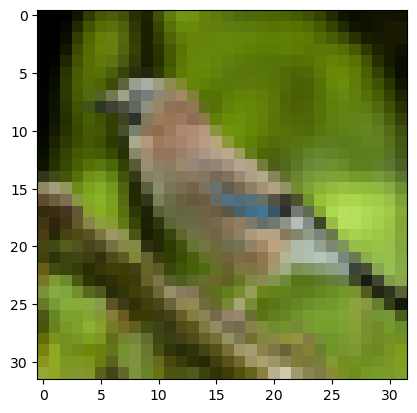

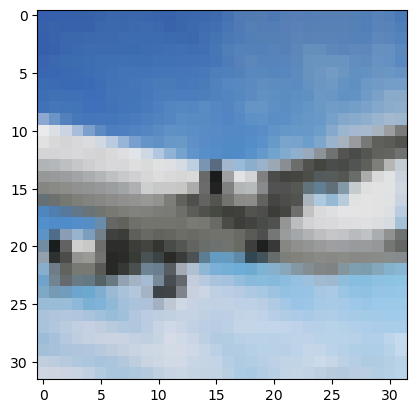

In [31]:
bird_img = imageio.imread("./dlwpt-code/cifar10/bird.jpeg")
plane_img = imageio.imread("./dlwpt-code/cifar10/plane.jpg")


def preprocess(img):
    min_size = min(img.shape[0:2])
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(min_size),
        transforms.Resize(32)
    ])
    return trans(img)


bird_img_t = preprocess(bird_img)
plane_img_t = preprocess(plane_img)

print(bird_img_t.shape, plane_img_t.shape)

plt.imshow(bird_img_t.permute(1, 2, 0))
plt.show()

plt.imshow(plane_img_t.permute(1, 2, 0))
plt.show()

In [32]:
loaded_model.eval()

plane_out = loaded_model(plane_img_t.unsqueeze(0))
bird_out = loaded_model(bird_img_t.unsqueeze(0))

plane_pred = F.softmax(plane_out, dim=1)
bird_pred = F.softmax(bird_out, dim=1)

plane_pred, bird_pred

(tensor([[0.8754, 0.1246]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.0192, 0.9808]], grad_fn=<SoftmaxBackward0>))

In [33]:
def training_loop_l2_reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 1e-3
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)))
            train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
            val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)
            validate(model, train_loader, val_loader)

In [34]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [163]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetDropout()
optimizer = SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.
2024-04-02 10:28:40.840485 Epoch 1, Training loss 0.5661187849606678
Accuracy train: 0.77
Accuracy val: 0.78
2024-04-02 10:28:50.098421 Epoch 10, Training loss 0.3876038224074491
Accuracy train: 0.83
Accuracy val: 0.82
2024-04-02 10:29:01.263747 Epoch 20, Training loss 0.3535905848642823
Accuracy train: 0.85
Accuracy val: 0.84
2024-04-02 10:29:10.591187 Epoch 30, Training loss 0.3323629721524609
Accuracy train: 0.86
Accuracy val: 0.85
2024-04-02 10:29:20.273993 Epoch 40, Training loss 0.3155539203791102
Accuracy train: 0.87
Accuracy val: 0.87
2024-04-02 10:29:30.069885 Epoch 50, Training loss 0.297554866998059
Accuracy train: 0.87
Accuracy val: 0.86
2024-04-02 10:29:39.540431 Epoch 60, Training loss 0.28623335765805213
Accuracy train: 0.88
Accuracy val: 0.87
2024-04-02 10:29:48.646111 Epoch 70, Training loss 0.2679836955989242
Accuracy train: 0.89
Accuracy val: 0.87
2024-04-02 10:29:57.766404 Epoch 80, Training loss 0.2602039215860853
Accuracy train: 0.89
Accura

In [36]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetBatchNorm()
optimizer = Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.
2024-04-02 11:06:19.066383 Epoch 1, Training loss 0.4724879243950935
Accuracy train: 0.80
Accuracy val: 0.81


KeyboardInterrupt: 

In [37]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32) -> None:
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [38]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [171]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetDepth()
optimizer = SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.
2024-04-02 10:43:51.399768 Epoch 1, Training loss 0.6885622185506638
Accuracy train: 0.58
Accuracy val: 0.58
2024-04-02 10:44:16.958422 Epoch 10, Training loss 0.3420196023716289
Accuracy train: 0.83
Accuracy val: 0.83
2024-04-02 10:44:45.780191 Epoch 20, Training loss 0.299369502788896
Accuracy train: 0.85
Accuracy val: 0.85
2024-04-02 10:45:28.888219 Epoch 30, Training loss 0.2666043457901402
Accuracy train: 0.86
Accuracy val: 0.86
2024-04-02 10:45:51.603367 Epoch 40, Training loss 0.23676126535720887
Accuracy train: 0.88
Accuracy val: 0.87
2024-04-02 10:46:27.010403 Epoch 50, Training loss 0.2074163774870763
Accuracy train: 0.89
Accuracy val: 0.88
2024-04-02 10:47:05.574847 Epoch 60, Training loss 0.1788253163693437
Accuracy train: 0.92
Accuracy val: 0.89
2024-04-02 10:48:09.783295 Epoch 70, Training loss 0.1510206805720071
Accuracy train: 0.93
Accuracy val: 0.90
2024-04-02 10:49:02.308420 Epoch 80, Training loss 0.12368452136114144
Accuracy train: 0.95
Accur

In [39]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetRes()
optimizer = SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.


KeyboardInterrupt: 

In [40]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [42]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
# Можно теперь запустить ее в течение намного большего числа эпох и посмотреть,
# каких результатов удастся добиться.

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = NetResDeep()
optimizer = SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop_with_validation(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Training on device cpu.
2024-04-02 11:10:28.497490 Epoch 1, Training loss 0.46019726858776844
Accuracy train: 0.84
Accuracy val: 0.82
2024-04-02 11:11:12.372468 Epoch 10, Training loss 0.2266258199693291
Accuracy train: 0.90
Accuracy val: 0.86
2024-04-02 11:12:00.773562 Epoch 20, Training loss 0.13124276119859735
Accuracy train: 0.94
Accuracy val: 0.87
2024-04-02 11:12:49.727652 Epoch 30, Training loss 0.06858943145911975
Accuracy train: 0.97
Accuracy val: 0.87
2024-04-02 11:13:38.747251 Epoch 40, Training loss 0.02252037141614469
Accuracy train: 0.99
Accuracy val: 0.89
2024-04-02 11:14:27.437812 Epoch 50, Training loss 0.01110575489468493
Accuracy train: 1.00
Accuracy val: 0.89
2024-04-02 11:15:16.814635 Epoch 60, Training loss 0.006376116509122216
Accuracy train: 1.00
Accuracy val: 0.89
2024-04-02 11:16:05.534167 Epoch 70, Training loss 0.004239882455225203
Accuracy train: 1.00
Accuracy val: 0.89
2024-04-02 11:16:58.489008 Epoch 80, Training loss 0.003105261142863922
Accuracy train: 

In [54]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [56]:
%ls ./output/

events.out.tfevents.1711756825.cvhost.55072.0
events.out.tfevents.1711756936.cvhost.55072.1
events.out.tfevents.1711757609.cvhost.55998.0
events.out.tfevents.1711758040.cvhost.55998.1
events.out.tfevents.1712004786.cvhost.95128.0
events.out.tfevents.1712005282.cvhost.95128.1
events.out.tfevents.1712005375.cvhost.95128.2
events.out.tfevents.1712005882.cvhost.95128.3
events.out.tfevents.1712005923.cvhost.95128.4
events.out.tfevents.1712006058.cvhost.95128.5
events.out.tfevents.1712006145.cvhost.95888.0
events.out.tfevents.1712006332.cvhost.95888.1
events.out.tfevents.1712006483.cvhost.95888.2
events.out.tfevents.1712006554.cvhost.95888.3
events.out.tfevents.1712008107.cvhost.95888.4
last_checkpoint
metrics.json
model_final.pth
